# Solving XOR problem

In [1]:

import os
import random

import torch
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

use_cuda = False
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
# %matplotlib inline
# %matplotlib qt

## How to make Dataset  
* torch.utils.data.Dataset을 상속받는 Class를 정의한다.
  * 다음의 두 method는 필수적으로 정의하여야 한다.
  * __len__(self) : Dataset의 크기를 return 한다.
  * __getitem__(self, idx) : 데이터셋의 idx번째 데이터를 return 한다.
  
  
* torch.utils.data.DataLoader에서 Dataset을 받아 batch로 만드는 역할을 한다.
  * enumerate(dataloader)를 통해 Dataset에 있는 data를 batch 단위로 받아올 수 있다.
  ~~~python
  for batch_idx, data, label in enumerate(trainloader)
        pass
  ~~~

 
 ## XOR Dataset
* 다음과 같은 XOR dataset을 만든다.

* Generate random (x, y) using torch.randn function 
    * 그리고 생성한 수에 2를  곱하세요.
* if x * y < 0 then label should be 0 
* else (x * y >= 0) then label should be 1 

In [2]:
class XOR(Dataset):
    def __init__(self, num_data=5000):
        super().__init__()

        self.data = torch.randn(num_data, 2) * 2
        
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        label = self.data[idx,0] * self.data[idx,1] >= 0
        label = label.to(torch.int)
        return self.data[idx,:], label
    
#     Test case #1
#  - check the size of dataset
#  - check the contents of dataset

train_XOR = XOR(num_data=5000)
test_XOR = XOR(num_data=1000)
assert len(train_XOR) == 5000, "The length of training set should be 5000."
assert len(test_XOR) == 1000, "The length of test set should be 1000."
is_passed = True
for data, label in train_XOR:
    if label.dtype != torch.int:
        is_passed = False
    if label not in [0,1]:
        is_passed = False
for data, label in test_XOR:
    if label.dtype != torch.int:
        is_passed = False
    if label not in [0,1]:
        is_passed = False

assert is_passed, "The label of dataset should be int tensor and 0 or 1"

In [3]:
train_loader = DataLoader(train_XOR, batch_size=32, shuffle=True)
test_loader = DataLoader(test_XOR, batch_size=1, shuffle=True)

[&lt;matplotlib.lines.Line2D at 0x7fe8cf609e48&gt;]

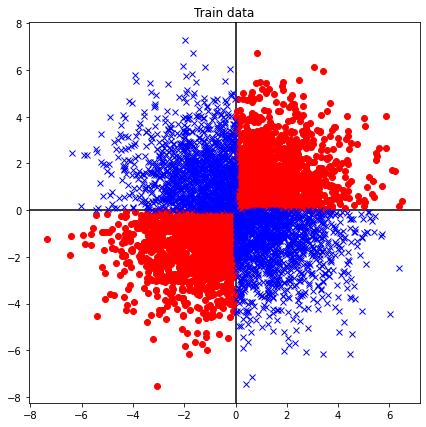

In [4]:
true_list = []
false_list = []
label_list = []
for data, label in train_XOR:
    if label ==1:
        true_list.append(data.numpy())
    else:
        false_list.append(data.numpy())

true_x = np.array(true_list).squeeze()[:, 0]
true_y = np.array(true_list).squeeze()[:, 1]
false_x = np.array(false_list).squeeze()[:, 0]
false_y = np.array(false_list).squeeze()[:, 1]

plt.figure(figsize=(7, 7))

plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.title('Train data')

plt.plot(true_x, true_y, 's', markersize=6, marker='o', color='r')
plt.plot(false_x, false_y, 's', markersize=6, marker='x', color='b')

## Define a Deep Neural Network
* Single layer network
    * Fully connected layer - in_features: 2, out_features: 1


* DNN
    * Fully connected layer - in_features: 2, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 1
    
    
* Note
    * Apply ReLU activation function for hidden layers.
    * Apply Sigmoid activation function for output layers.


In [5]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,1)
    
    def forward(self, x):
        output = torch.sigmoid(self.fc1(x))
        return output

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2,20)
        self.fc2 = torch.nn.Linear(20,20)
        self.fc3 = torch.nn.Linear(20,1)
    
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = torch.sigmoid(self.fc3(output))
        return output

model_single = ANN().to(device)
model_dnn = DNN().to(device)

#     Test case #2
#  - check the default output of model before training
#  - make sure that the definition of layers in your model is correct.

model_single(torch.tensor([[0.1,0.1]]))
print('Target:')
s= """ANN(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)"""
print(s)
print('Actual:')
print(str(model_single))
assert str(model_single) == s

model_dnn(torch.tensor([[0.1,0.1]]))
print('Target:')
s= """DNN(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)"""
print(s)
print('Actual:')
print(str(model_dnn))
assert str(model_dnn) == s

Target:
ANN(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)
Actual:
ANN(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)
Target:
DNN(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)
Actual:
DNN(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


### Define a Loss function and optimizer
* Use Bineary Cross-Entropy loss
* Use SGD with learning rate 0.01 and momentum 0.5

In [12]:
# TODO: define a loss and optimizer
criterion = nn.BCELoss()

def create_optimizer(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)    
    return optimizer


### Train the network on the training data

In [13]:
def train(model, num_epochs):
    model.train()
    optimizer = create_optimizer(model)
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.float())
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data))


def test(model):
    predict_true = []            
    predict_false = []
    
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)


        output = model(data)

        test_loss += criterion(output, target.float()).data # sum up batch loss
        pred = torch.round(output).data # get the index of the max log-probability
        correct += pred.eq(target.data.float().view_as(pred)).cpu().sum()
        if pred.sum() == 0:
            predict_false.append(data.data.tolist())
        else:
            predict_true.append(data.data.tolist())

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return predict_true, predict_false

In [14]:
# TODO: train and test single layer network
train(model_single, 5)
predict_true_single, predict_false_single = test(model_single)

/home/piai/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
Train Epoch: 0 [0/5000 (0%)]	Loss: 0.682475
Train Epoch: 0 [320/5000 (6%)]	Loss: 0.684778
Train Epoch: 0 [640/5000 (13%)]	Loss: 0.698713
Train Epoch: 0 [960/5000 (19%)]	Loss: 0.680880
Train Epoch: 0 [1280/5000 (25%)]	Loss: 0.684974
Train Epoch: 0 [1600/5000 (32%)]	Loss: 0.690241
Train Epoch: 0 [1920/5000 (38%)]	Loss: 0.686595
Train Epoch: 0 [2240/5000 (45%)]	Loss: 0.696524
Train Epoch: 0 [2560/5000 (51%)]	Loss: 0.690001
Train Epoch: 0 [2880/5000 (57%)]	Loss: 0.692796
Train Epoch: 0 [3200/5000 (64%)]	Loss: 0.694152
Train Epoch: 0 [3520/5000 (70%)]	Loss: 0.697272
Train Epoch: 0 [3840/5000 (76%)]	Loss: 0.693743
Train Epoch: 0 [4160/5000 (83%)]	Loss: 0.692022
Tra

In [15]:
# TODO: train and test DNN
train(model_dnn, 5)
predict_true_dnn, predict_false_dnn = test(model_dnn)

Train Epoch: 0 [0/5000 (0%)]	Loss: 0.237417
Train Epoch: 0 [320/5000 (6%)]	Loss: 0.094866
Train Epoch: 0 [640/5000 (13%)]	Loss: 0.213528
Train Epoch: 0 [960/5000 (19%)]	Loss: 0.180724
Train Epoch: 0 [1280/5000 (25%)]	Loss: 0.176301
Train Epoch: 0 [1600/5000 (32%)]	Loss: 0.162616
Train Epoch: 0 [1920/5000 (38%)]	Loss: 0.173760
Train Epoch: 0 [2240/5000 (45%)]	Loss: 0.120702
Train Epoch: 0 [2560/5000 (51%)]	Loss: 0.202717
Train Epoch: 0 [2880/5000 (57%)]	Loss: 0.154562
Train Epoch: 0 [3200/5000 (64%)]	Loss: 0.233427
Train Epoch: 0 [3520/5000 (70%)]	Loss: 0.248093
Train Epoch: 0 [3840/5000 (76%)]	Loss: 0.125025
Train Epoch: 0 [4160/5000 (83%)]	Loss: 0.140222
Train Epoch: 0 [4480/5000 (89%)]	Loss: 0.147641
Train Epoch: 0 [4800/5000 (96%)]	Loss: 0.164251
Train Epoch: 1 [0/5000 (0%)]	Loss: 0.166172
Train Epoch: 1 [320/5000 (6%)]	Loss: 0.110376
Train Epoch: 1 [640/5000 (13%)]	Loss: 0.218376
Train Epoch: 1 [960/5000 (19%)]	Loss: 0.156226
Train Epoch: 1 [1280/5000 (25%)]	Loss: 0.182345
Train Ep

### Test the network on the test data

[&lt;matplotlib.lines.Line2D at 0x7fe8cc4642b0&gt;]

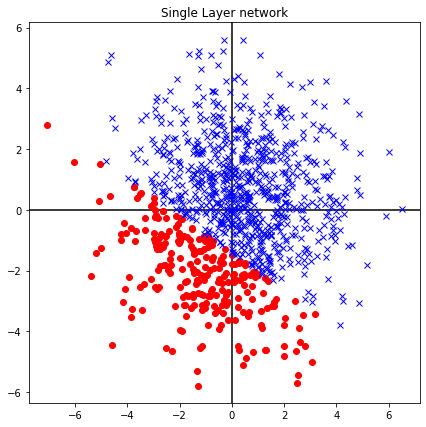

In [10]:
predict_true_x = np.array(predict_true_single).squeeze()[:, 0]
predict_true_y = np.array(predict_true_single).squeeze()[:, 1]
predict_false_x = np.array(predict_false_single).squeeze()[:, 0]
predict_false_y = np.array(predict_false_single).squeeze()[:, 1]

plt.figure(figsize=(7, 7))

plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.title('Single Layer network')

plt.plot(predict_true_x, predict_true_y, 's', markersize=6, marker='o', color='r')
plt.plot(predict_false_x, predict_false_y, 's', markersize=6, marker='x', color='b')

[&lt;matplotlib.lines.Line2D at 0x7fe8c02dac18&gt;]

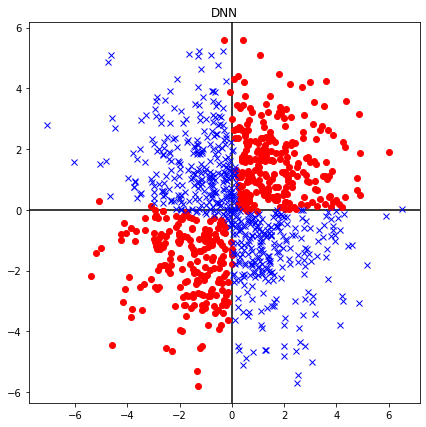

In [11]:
predict_true_x = np.array(predict_true_dnn).squeeze()[:, 0]
predict_true_y = np.array(predict_true_dnn).squeeze()[:, 1]
predict_false_x = np.array(predict_false_dnn).squeeze()[:, 0]
predict_false_y = np.array(predict_false_dnn).squeeze()[:, 1]

plt.figure(figsize=(7, 7))

plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.title('DNN')

plt.plot(predict_true_x, predict_true_y, 's', markersize=6, marker='o', color='r')
plt.plot(predict_false_x, predict_false_y, 's', markersize=6, marker='x', color='b')